In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/outta/clothes_segmentation

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/outta/clothes_segmentation


In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import torch
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.functional import F
from tqdm.auto import tqdm

from codes.load_testset import load_testset
from codes.show_result import show_segment, show_test_output
from models.u2_net import U2NET_lite
from loss.scloss import SCLoss

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
model = U2NET_lite(7).to(device=device)

In [6]:
train_loader, valid_loader = load_testset('../outta_3_project/dataset/G2_train.h5', 8000, 2000)
# 개인 데이터셋 경로로 지정할 것

torch.Size([8000, 3, 128, 128]) torch.Size([8000, 128, 128])


In [13]:
test_input = None
test_label = None
for i, j in valid_loader:
    test_input = i[0]
    test_label = j[0]

In [18]:
criterion = CrossEntropyLoss()
sc_loss = SCLoss()
optimizer = Adam(model.parameters(), lr=1e-4)

In [25]:
def train_valid(model, criterion, sc_loss, L,optimizer, trainloader, validloader, num_epochs=1):
    count = 0
    train_losses = []
    valid_losses = []

    for epoch in tqdm(range(num_epochs)):
        train_losses.append(epoch_loop(model, criterion, sc_loss, L,optimizer, trainloader))
        valid_losses.append(epoch_loop(model, criterion, sc_loss, L,optimizer, validloader, valid = True))
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Valid Loss: {valid_losses[-1]}')
        show_test_output(model, test_input, test_label, device)


        if train_losses[-1] > valid_losses[-1]:
            count += 1
            if count > 3:
                print('early stop')


        if min(valid_losses) == valid_losses[-1]:
            torch.save(model.state_dict(), f'../../../../model_{epoch}.pth')


    return train_losses, valid_losses

In [26]:
def epoch_loop(model, criterion, sc_loss, L, optimizer, dataloader, valid=False):
    epoch_loss = 0

    if valid:
        model.eval()
    else:
        model.train()

    for inputs, targets in tqdm(dataloader, leave=False):
        inputs, targets = inputs.to(device), targets.to(device)
        targets = targets.long()

        # Forward pass
        outputs = model(inputs)

        # Main Loss 계산 (CrossEntropyLoss)
        ce_loss = criterion(outputs, targets)

        # SCLoss 계산
        outputs_probs = F.softmax(outputs, dim=1)
        targets_onehot = F.one_hot(targets, num_classes=outputs.shape[1]).permute(0, 3, 1, 2).float()
        sc_loss_value = sc_loss(outputs_probs, targets_onehot)

        loss = ce_loss + L * sc_loss_value

        if not valid:
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        epoch_loss += loss.item()

        del inputs, targets, outputs, ce_loss, outputs_probs, targets_onehot, sc_loss_value, loss
        torch.cuda.empty_cache()

    return epoch_loss/len(dataloader)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1/10, Train Loss: 0.2625269873738289, Valid Loss: 0.12506184880695645


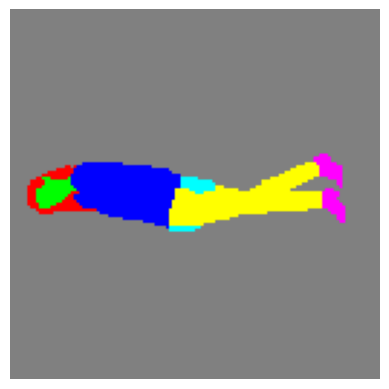

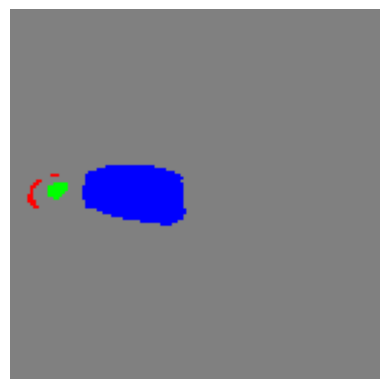

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2/10, Train Loss: 0.10445163038372994, Valid Loss: 0.09605278985367881


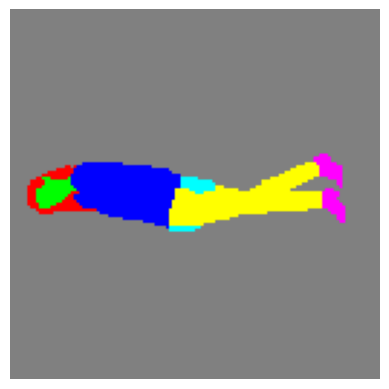

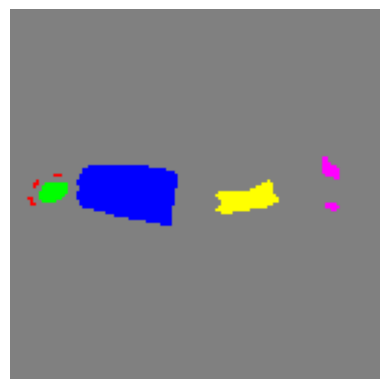

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3/10, Train Loss: 0.0863826029598713, Valid Loss: 0.0839534637237352


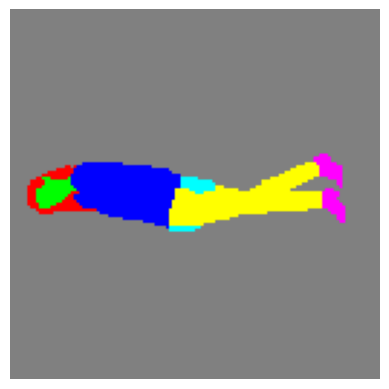

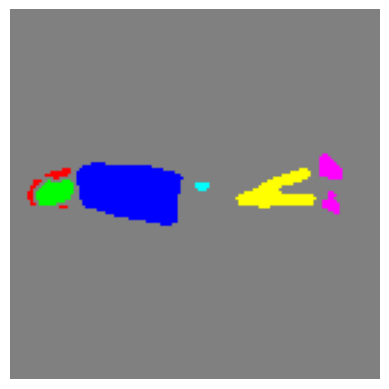

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 4/10, Train Loss: 0.07673708759248257, Valid Loss: 0.07960189293537821


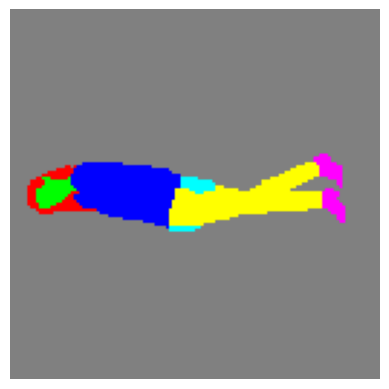

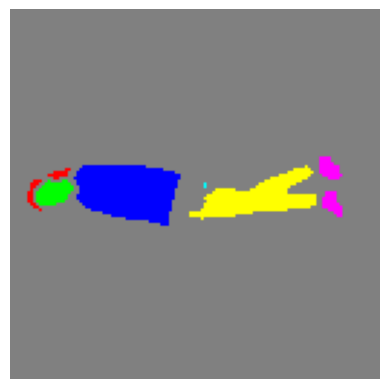

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5/10, Train Loss: 0.07147868506610394, Valid Loss: 0.07478642363160376


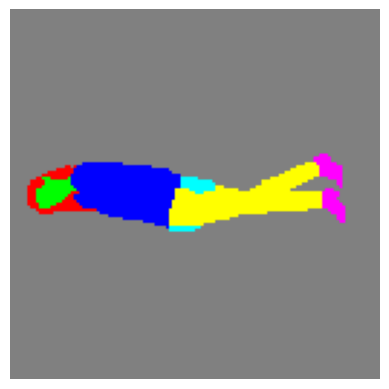

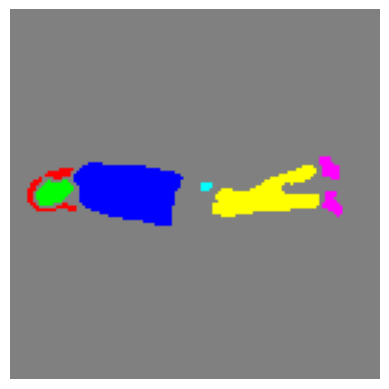

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 6/10, Train Loss: 0.06669457733631134, Valid Loss: 0.07396805611631227


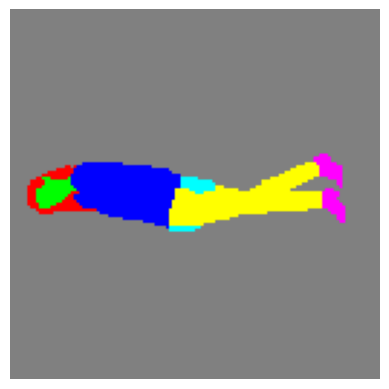

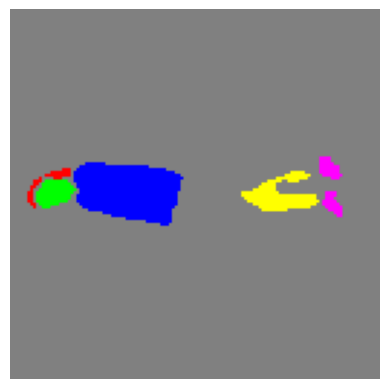

  0%|          | 0/250 [00:00<?, ?it/s]

In [ ]:
train_valid(model, criterion, sc_loss, 0.1, optimizer, train_loader, valid_loader, num_epochs=10)